In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from datasets import load_dataset
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np

/opt/anaconda3/envs/huggingface/lib/python3.13/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


## Step 1: Load the Fashion MNIST dataset from Hugging Face

In [2]:
# Load the dataset directly from Hugging Face
dataset = load_dataset("fashion_mnist")

README.md:   0%|          | 0.00/9.02k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/30.9M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/5.18M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

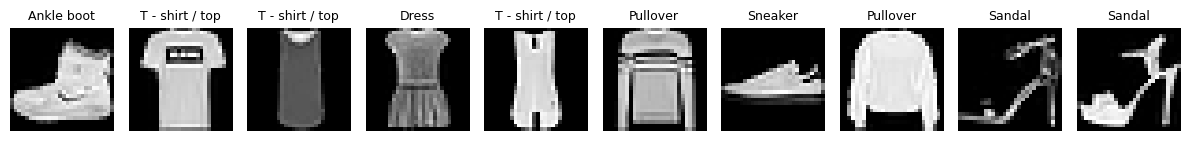

In [6]:
# Get the label names from the dataset
class_names = dataset['train'].features['label'].names

def show_samples(dataset, num_images=10):
    plt.figure(figsize=(12, 2))
    for i in range(num_images):
        image = dataset['train'][i]['image']
        label = dataset['train'][i]['label']
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(class_names[label], fontsize=9)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show 10 sample images
show_samples(dataset)

## Step 2: Processing dataset for model training

In [7]:
# Convert images to tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [8]:
# Wrap the Hugging Face dataset as a PyTorch Dataset
class FashionDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        label = self.dataset[idx]['label']
        if self.transform:
            image = self.transform(image)
        return image, label

In [9]:
# Prepare training, validation, and test sets

# Split training into train/validation sets
full_train_dataset = FashionDataset(dataset['train'], transform=transform)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Prepare test set
test_dataset = FashionDataset(dataset['test'], transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

## Step 3: Define a simple CNN model

In [10]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # (1, 28, 28) -> (32, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                         # -> (32, 14, 14)
            nn.Conv2d(32, 64, kernel_size=3, padding=1),# -> (64, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                         # -> (64, 7, 7)
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)                          # 10 output classes
        )

    def forward(self, x):
        return self.model(x)

## Step 4: Model training

In [12]:
# Set up training configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

# CrossEntropyLoss applies softmax + loss in one step
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
# Add a global list to store training loss per epoch
train_losses = []

# Model training function
def train_model(num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

In [15]:
# Train the model
train_model()

Epoch 1, Loss: 0.1631
Epoch 2, Loss: 0.1391
Epoch 3, Loss: 0.1189
Epoch 4, Loss: 0.1004
Epoch 5, Loss: 0.0871


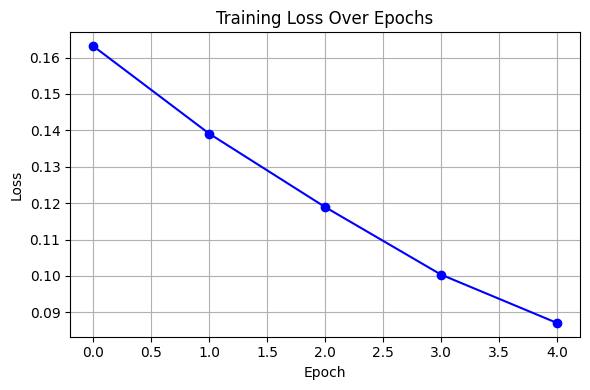

In [16]:
# Plot training loss over epochs
def plot_training_curve():
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, marker='o', color='blue')
    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call this after training
plot_training_curve()

## Evaluate the model on the test set

In [18]:
def evaluate_model(loader, show_examples=False):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")
    print("\nClassification Report:\n", classification_report(all_labels, all_preds))

    # Show a few prediction examples
    if show_examples:
        fig, axs = plt.subplots(2, 5, figsize=(12, 5))
        class_names = dataset['train'].features['label'].names

        images, labels = next(iter(loader))
        outputs = model(images.to(device))
        _, preds = torch.max(outputs, 1)

        for i in range(10):
            ax = axs[i//5][i%5]
            ax.imshow(images[i].squeeze(), cmap="gray")
            ax.set_title(f"P: {class_names[preds[i]]}\nT: {class_names[labels[i]]}")
            ax.axis("off")
        plt.tight_layout()
        plt.show()

Accuracy: 91.70%

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87      1000
           1       0.97      0.99      0.98      1000
           2       0.89      0.86      0.88      1000
           3       0.94      0.88      0.91      1000
           4       0.85      0.90      0.88      1000
           5       0.99      0.97      0.98      1000
           6       0.76      0.78      0.77      1000
           7       0.94      0.99      0.96      1000
           8       0.97      0.98      0.98      1000
           9       0.98      0.95      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



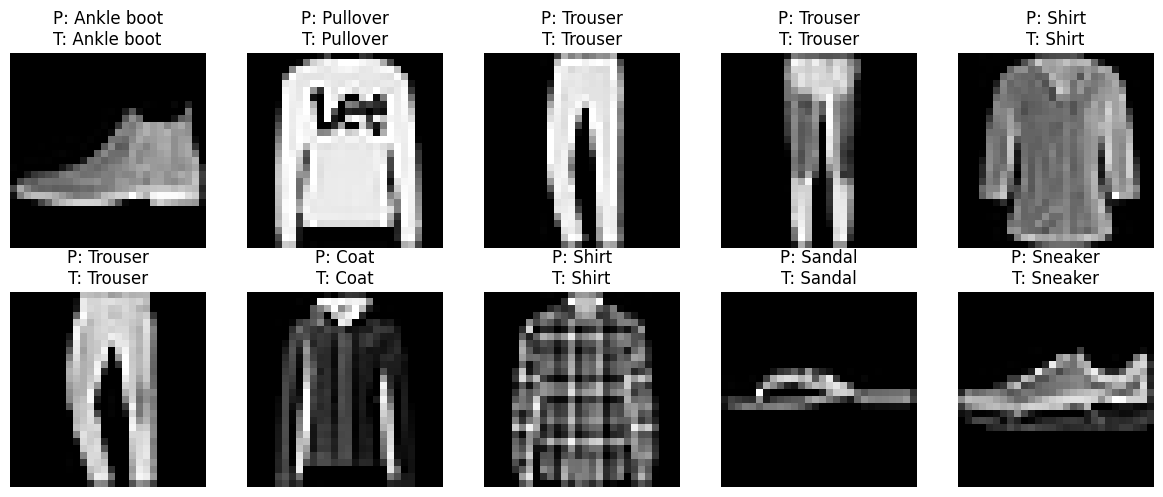

In [19]:
evaluate_model(test_loader, show_examples=True)